In [61]:
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
from statistics import mean

In [62]:
def loop_grid(matrix, mkd, a, width, height, neighbours):
    
    # protential grid
    transH = np.ones((width, height))
    transI = np.ones((width, height))
    transC = np.ones((width, height))
    
    list_distances = [1, 1.4, 2, 2.2, 2.8, 3, 3.2, 3.6, 4, 4.1, 4.2, 4.5, 5, 5.1, 5.4, 5.7, 5.8, 6, 6.1, 6.3, 6.4, 6.7, 7.1, 7.2, 7.8, 8.5]
    
    #i,j current house grid
    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            # k,l is neighbourhood
            for k in range(i-(neighbours), i+(neighbours+1)):
                for l in range(j-(neighbours), j+(neighbours+1)):
                    
                    #only if neighboorhoud exists
#                   check if the neigbours are inside grid
                    if k < 0 or k > (width-1) or l < 0 or l > (height-1):
                        continue
            
                    else:
                        '''zoek op in dict:
                        ik ben zelf Matrix[i,j]
                        ik kijk naar Matrix[k,l]
                        ik kan worden loop [H, I, C] en update probabilitygrid
                        Eet een koekje
                        '''  
                    
#                       als degene waar je naar kijkt een huis is
                        if matrix[k, l] != 0 and (k, l) != (i, j) and matrix[i, j] != 3:
        
#                           op basis van hoe ver het huis van je vandaan zit krijg je een score uit de mkd
                            # Trans House potential
    
                            distance = round(np.sqrt((abs(i - k))**2 + (abs(l - j))**2), 1)
                            index_distance = list_distances.index(distance)
    
    
                            # kans op house worden, met wat we zelf zijn (matrix[i, j]) bepaald door plek waar we kijken en distance
#                             print(mkd[int(matrix[i, j])][1][int(matrix[k, l])][distance])
                            if matrix[i, j] != 2 and matrix[i, j] != 3:
                                transH[i, j] += mkd[int(matrix[i, j])][1][int(matrix[k, l])-1][index_distance]
            
                            # Trans Industry potential
                            if matrix[i, j] != 3:
                                transI[i, j] += mkd[int(matrix[i, j])][2][int(matrix[k, l])-1][index_distance]
                    
                            # Trans Commerce potential
                            transC[i, j] += mkd[int(matrix[i, j])][3][int(matrix[k, l])-1][index_distance]
                            
    for i in range(len(transH)):
        for j in range(len(transH[0])):
            S = 1 + (-np.log(random.random()))**(a)
            transH[i, j] *= S
            S = 1 + (-np.log(random.random()))**(a)
            transI[i, j] *= S
            S = 1 + (-np.log(random.random()))**(a)
            transC[i, j] *= S
            

    return transH, transI, transC

In [63]:
def simulate_growth(city, width, height, steps, Nh, a, mkd, n):
    citiesovertime = []

    for step in range(steps):
        transH, transI, transC = loop_grid(city, mkd, a, width, height, n)

        orderedhouses = transH.flatten().argsort()[::-1]
        orderedindustry = transI.flatten().argsort()[::-1]
        orderedcommerce = transC.flatten().argsort()[::-1]

        newhouses = orderedhouses[0:round((((width*height)*Nh)/12)*7)]
        for house in range(round((((width*height)*Nh)/12)*7)):
            orderedhouses = np.delete(orderedhouses, house)

        newindustry = orderedindustry[0:round((((width*height)*Nh)/12)*4)]
        for ind in range(round((((width*height)*Nh)/12)*4)):
            orderedindustry = np.delete(orderedindustry, ind)

        newcommerce = orderedcommerce[0:round(((width*height)*Nh)/12)]
        for com in range(round(((width*height)*Nh)/12)):
            orderedcommerce = np.delete(orderedcommerce, com)

        while len(set(newcommerce) & set(newindustry)) != 0:
            for doubleindex in (set(newcommerce) & set(newindustry)):
                if transI[doubleindex//width, doubleindex%height] > transC[doubleindex//width, doubleindex%height]:
                    newcommerce = np.delete(newcommerce, np.where(newcommerce == doubleindex)[0])
                    newcommerce = np.append(newcommerce, orderedcommerce[0])
                    orderedcommerce = np.delete(orderedcommerce, 0)
                else:
                    newindustry = np.delete(newindustry, np.where(newindustry == doubleindex)[0])
                    newindustry = np.append(newindustry, orderedindustry[0])
                    orderedindustry = np.delete(orderedindustry, 0)

        while len(set(newcommerce) & set(newhouses)) != 0:
            for doubleindex in (set(newcommerce) & set(newhouses)):
                if transH[doubleindex//width, doubleindex%height] > transC[doubleindex//width, doubleindex%height]:
                    newcommerce = np.delete(newcommerce, np.where(newcommerce == doubleindex)[0])
                    newcommerce = np.append(newcommerce, orderedcommerce[0])
                    orderedcommerce = np.delete(orderedcommerce, 0)
                else:
                    newhouses = np.delete(newhouses, np.where(newhouses == doubleindex)[0])
                    newhouses = np.append(newhouses, orderedhouses[0])
                    orderedhouses = np.delete(orderedhouses, 0)

        while len(set(newhouses) & set(newindustry)) != 0:
            for doubleindex in (set(newhouses) & set(newindustry)):
                if transI[doubleindex//width, doubleindex%height] > transH[doubleindex//width, doubleindex%height]:
                    newhouses = np.delete(newhouses, np.where(newhouses == doubleindex)[0])
                    newhouses = np.append(newhouses, orderedhouses[0])
                    orderedhouses = np.delete(orderedhouses, 0)
                else:
                    newindustry = np.delete(newindustry, np.where(newindustry == doubleindex)[0])
                    newindustry = np.append(newindustry, orderedindustry[0])
                    orderedindustry = np.delete(orderedindustry, 0)


        for com in newcommerce:
            city[com//width, com%height] = 3

        for indus in newindustry:
            if city[indus//width, indus%height] != 3:
                city[indus//width, indus%height] = 2

        for house in newhouses:
            if city[house//width, house%height] != 2 and city[house//width, house%height] != 3:
                city[house//width, house%height] = 1

        citiesovertime.append(copy.deepcopy(city))
        
        plt.matshow(city, vmin = 0, vmax = 3, cmap = 'Greys')
        plt.colorbar()
        plt.show()
        
    return citiesovertime

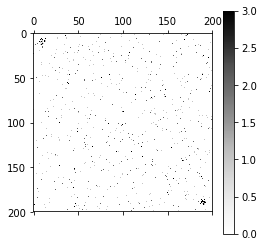

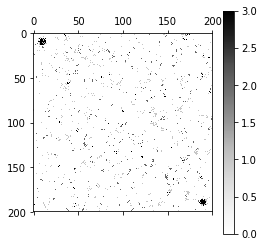

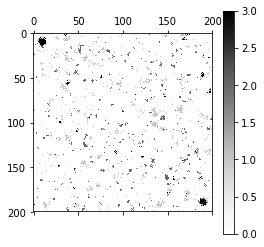

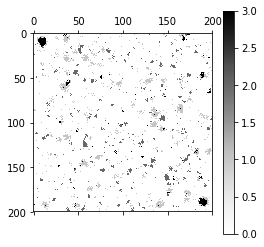

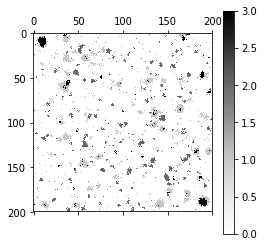

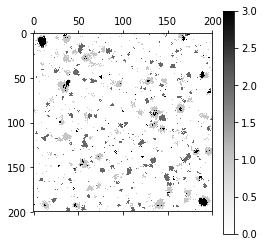

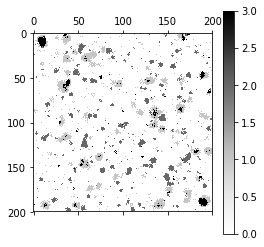

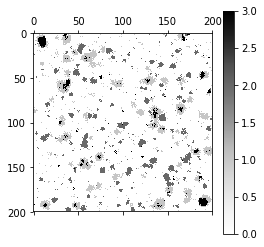

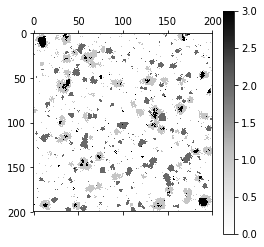

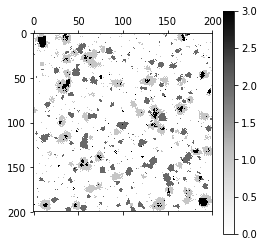

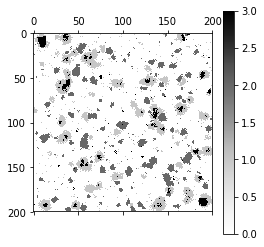

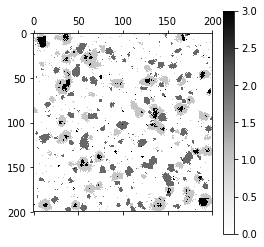

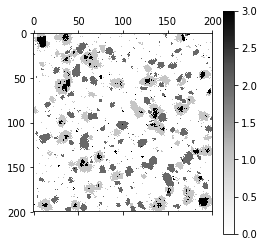

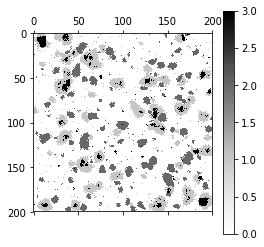

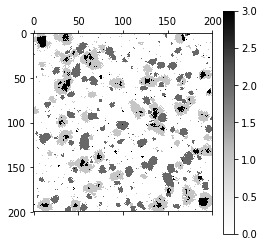

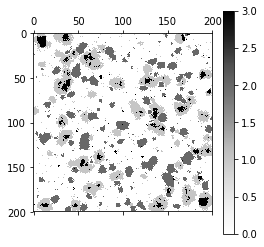

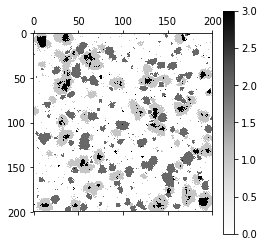

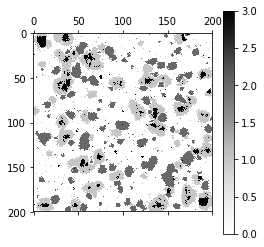

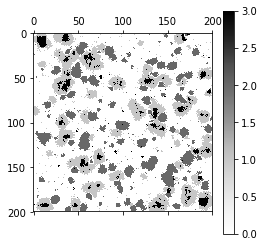

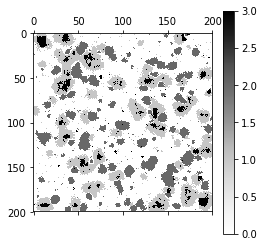

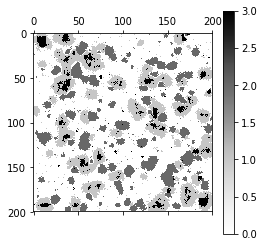

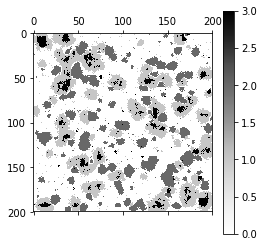

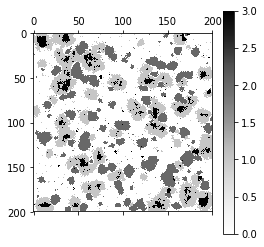

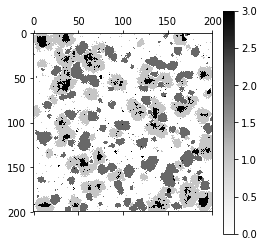

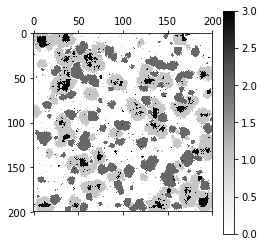

In [64]:
# V, H, I, C
# 0, 1, 2, 3

width = 200
height = 200

initialcity = np.zeros((width, height))

steps = 25

initialcity[10, 10] = 1
initialcity[190, 190] = 1
Nh = 0.02
a = 1
n = 2

mkd = {0: {1: [[2,2,1.5,1.5,1,1,1,1,0.5,0.5,0.5,0.5,0.5,0.1,0.1,0.1,0.1,0.1,0,0,0,0,0,0,0,0], 
               [-10,-10,-5,-3,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
               [-2,-1,2,1,1,1,0.5,0.5,0.4,0.3,0.2,0.1,0.1,0.1,0,0,0,0,0,0,0,0,0,0,0,0]], 
           2: [[-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
               [3,3,2,1,0,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]], 
           3: [[4,3.5,3,2.5,2,2,2,1.5,1.5,1.5,1.5,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
               [25,25,25,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,0,0,0,0,0]]}, 
       1: {1: [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
               [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
               [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]], 
           2: [[-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
               [2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
               [1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]], 
           3: [[4,3.5,3,2.5,2,2,2,1.5,1.5,1.5,1.5,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0], 
               [1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
               [25,25,25,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0]]},
       2: {1: [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
               [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
               [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]], 
           2: [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
               [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]], 
           3: [[4,3.5,3,2.5,2,2,2,1.5,1.5,1.5,1.5,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0], 
               [-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
               [25,25,25,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0]]}}

n = 3
citiesovertime = simulate_growth(initialcity, width, height, steps, Nh, a, mkd, n)



[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   1   1 ...   0   0   0]
 ...
 [  0   0   0 ... 220   0 220]
 [  0   0 243 ... 220 220   0]
 [  0   0   0 ... 220   0   0]]
area: [  13.   21.   22.   34.   45.   57.   64.   74.   74.   82.   82.   93.
  104.  108.  136.  155.  189.  198.  200.  230.  230.  254.  281.  308.
  388.  453.  470.  562.  652.  775. 1080. 1552. 2562.]
sorted [2.56494936 3.04452244 3.09104245 3.52636052 3.80666249 4.04305127
 4.15888308 4.30406509 4.30406509 4.40671925 4.40671925 4.53259949
 4.6443909  4.68213123 4.91265489 5.04342512 5.24174702 5.28826703
 5.29831737 5.43807931 5.43807931 5.53733427 5.63835467 5.73009978
 5.96100534 6.11589213 6.15273269 6.33150185 6.48004456 6.65286303
 6.98471632 7.3472997  7.84854348]


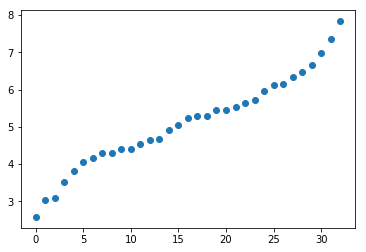

In [67]:
from pylab import *
from scipy.ndimage import measurements

s = [[1,1,1],
    [1,1,1],
    [1,1,1]]

testM = citiesovertime[24]
testM[testM == 3] = 1
testM[testM == 2] = 0
lw, num = measurements.label(testM, structure = s)
print(lw)
area = measurements.sum(testM, lw, index=arange(lw.max() + 1))
area = area[area>10]
print("area:", sort(area))
print("sorted", sort(log(area)))

plt.scatter(range(0, len(area)), sort(log(area)))
plt.show()

# plt.matshow(testM, vmin = 0, vmax = 3, cmap = 'Greys')
# plt.colorbar()
# plt.show()
